# DSA4263 E-Commerce Fraud Analysis

## Import Packages

In [1]:
# Uncomment if needed to install the packages
# pip install pandas numpy

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

## Data Loading

In [3]:
# Uncomment this cell when submitting

# df_fraud = pd.read_csv("data/Fraud_Data.csv")
# df_ip_to_country = pd.read_csv("data/IpAddress_to_Country.csv")

In [4]:
# Delete this cell when submitting

from google.colab import drive
drive.mount("/content/gdrive")
df_fraud = pd.read_csv("gdrive/MyDrive/Fraud_Data.csv")
df_ip_to_country = pd.read_csv("gdrive/MyDrive/IpAddress_to_Country.csv")

Mounted at /content/gdrive


## Data Preprocessing

In [5]:
df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [7]:
df_ip_to_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [8]:
df_ip_to_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [9]:
# Checking for null values and duplicates in Fraud_Data.csv

print(df_fraud.isna().sum())
print("--------------------")
print(df_fraud.duplicated().sum())

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
--------------------
0


In [10]:
# Checking for null values and duplicates in IpAddress_to_country.csv

print(df_ip_to_country.isna().sum())
print("--------------------")
print(df_ip_to_country.duplicated().sum())

lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64
--------------------
0


There are no null values and duplicate entries in both datasets.

In [11]:
# Checking for duplicates in `user_id` and `device_id` in Fraud_Data.csv

print("No. of duplicates in user_id:", df_fraud['user_id'].duplicated().sum())
print("No. of duplicates in device_id:", df_fraud['device_id'].duplicated().sum())

No. of duplicates in user_id: 0
No. of duplicates in device_id: 13156


While `user_id` are unique, there are repeated instances of `device_id`, indicating that multiple accounts have been created using the same device. Based on this observation, we will drop the `user_id` column from our model and retain the `device_id` column.

In [12]:
df_clean = df_fraud.drop('user_id', axis=1)

In [13]:
# Merge the datasets based on Ip Address

def find_country(ip_address, df_ip_ranges):
  country = df_ip_ranges[
      (df_ip_ranges['lower_bound_ip_address'] <= ip_address) &
      (df_ip_ranges['upper_bound_ip_address'] >= ip_address)
  ]['country'].values

  return country[0] if len(country) > 0 else 'Unknown'

country_values = df_clean['ip_address'].apply(find_country, df_ip_ranges=df_ip_to_country)

# Insert `country` column to the second last position of the columns
df_clean.insert(loc = len(df_clean.columns) - 1,
                column = 'country', value = country_values)

# Remove the Ip Address
df_clean.drop('ip_address', axis=1, inplace=True)

In [14]:
# Finding the number of rows with unknown country

print("No. of unknown country:", (df_clean['country'] == 'Unknown').sum())

No. of unknown country: 21966


In [15]:
# Removing rows with unkown country
#df_clean = df_clean[df_clean['country'] != 'Unknown']

In [16]:
df_clean.head()

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,country,class
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,Japan,0
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,United States,0
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,United States,1
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,Unknown,0
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,United States,0


In [17]:
# Extracting the year when customers signup for accounts
df_clean['signup_time'] = pd.to_datetime(df_clean['signup_time'], format='%Y-%m-%d %H:%M:%S')
df_clean['year'] = df_clean['signup_time'].dt.year
print("Earliest year for signup:", df_clean['year'].min())
print("Latest year for signup:", df_clean['year'].max())

Earliest year for signup: 2015
Latest year for signup: 2015


In [18]:
# Since the data is only for year 2015, we remove the year column
df_clean.drop('year', axis=1, inplace=True)

In [19]:
# Extracting the months when customers signup for accounts
df_clean['signup_month'] = df_clean['signup_time'].dt.month
# Range of the months when customers signup for accounts
print("Earliest month for signup:", df_clean['signup_month'].min())
print("Latest month for signup:", df_clean['signup_month'].max())

Earliest month for signup: 1
Latest month for signup: 8


In [20]:
# Extracting the days of the month when customers signup for accounts
df_clean['signup_day'] = df_clean['signup_time'].dt.day
print("Earliest day for signup:", df_clean['signup_day'].min())
print("Latest day for signup:", df_clean['signup_day'].max())

Earliest day for signup: 1
Latest day for signup: 31


In [21]:
# Extracting the year when customers made a purchase
df_clean['purchase_time'] = pd.to_datetime(df_clean['purchase_time'], format='%Y-%m-%d %H:%M:%S')
df_clean['purchase_year'] = df_clean['purchase_time'].dt.year
print("Earliest year for purchase:", df_clean['purchase_year'].min())
print("Latest year for purchase:", df_clean['purchase_year'].max())

Earliest year for purchase: 2015
Latest year for purchase: 2015


In [22]:
# Since the data is only for year 2015, we remove the year column
df_clean.drop('purchase_year', axis=1, inplace=True)

In [23]:
# Extracting the months when customers signup for accounts
df_clean['purchase_month'] = df_clean['purchase_time'].dt.month
# Range of the months when customers made purchases
print("Earliest month for purchase:", df_clean['purchase_month'].min())
print("Latest month for purchase:", df_clean['purchase_month'].max())

Earliest month for purchase: 1
Latest month for purchase: 12


In [24]:
# Extracting the days of the month when customers signup for accounts
df_clean['purchase_day'] = df_clean['purchase_time'].dt.day
print("Earliest day for purchase:", df_clean['purchase_day'].min())
print("Latest day for purchase:", df_clean['purchase_day'].max())

Earliest day for purchase: 1
Latest day for purchase: 31


In [25]:
# Finding out the difference in time between account creation time and time of purchase, in seconds
df_clean['signup_purchase_time_diff'] = (df_clean['purchase_time']-df_clean['signup_time']).dt.total_seconds()

In [26]:
print("Types of browsers used by customers:", df_clean['browser'].unique())
print("Types of genders of customers:", df_clean['sex'].unique())

Types of browsers used by customers: ['Chrome' 'Opera' 'Safari' 'IE' 'FireFox']
Types of genders of customers: ['M' 'F']


In [27]:
# Perform One-Hot Encoding to convert Browser, Sex and Source columns into numerical columns
ohe_df = pd.get_dummies(df_clean, columns=['browser','sex','source'])
ohe_df.head()

,signup_time,purchase_time,purchase_value,device_id,age,country,class,signup_month,signup_day,purchase_month,...,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,source_Ads,source_Direct,source_SEO
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,39,Japan,0,2,24,4,...,1,0,0,0,0,0,1,0,0,1
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,53,United States,0,6,7,6,...,1,0,0,0,0,1,0,1,0,0
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,53,United States,1,1,1,1,...,0,0,0,1,0,0,1,0,0,1
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,41,Unknown,0,4,28,5,...,0,0,0,0,1,0,1,0,0,1
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,45,United States,0,7,21,9,...,0,0,0,0,1,0,1,1,0,0


In [28]:
df_clean.head()

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,country,class,signup_month,signup_day,purchase_month,purchase_day,signup_purchase_time_diff
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,Japan,0,2,24,4,18,4506682.0
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,United States,0,6,7,6,8,17944.0
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,United States,1,1,1,1,1,1.0
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,Unknown,0,4,28,5,4,492085.0
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,United States,0,7,21,9,9,4361461.0


In [29]:
# Checking for class imbalance
print("Number of Non-Fraudulent transactions:", df_clean['class'].value_counts()[0])
print("Number of Fraudulent transactions:", df_clean['class'].value_counts()[1])

Number of Non-Fraudulent transactions: 136961
Number of Fraudulent transactions: 14151


Class imbalance exists.

## EDA

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

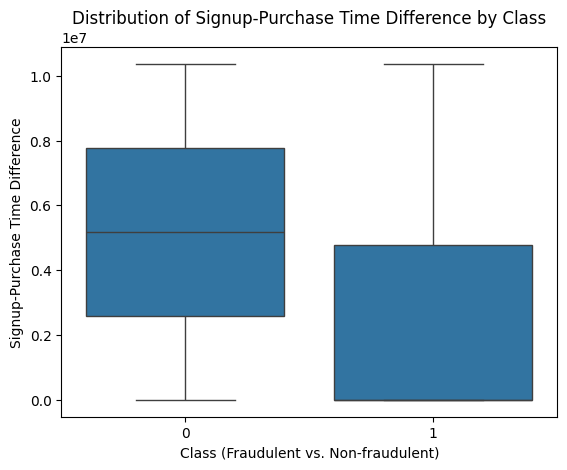

In [31]:
# Plotting boxplot to visualise the difference between signup-purchase time difference for each class
sns.boxplot(x='class', y='signup_purchase_time_diff', data=df_clean)
plt.xlabel('Class (Fraudulent vs. Non-fraudulent)')
plt.ylabel('Signup-Purchase Time Difference')
plt.title('Distribution of Signup-Purchase Time Difference by Class')
plt.show()

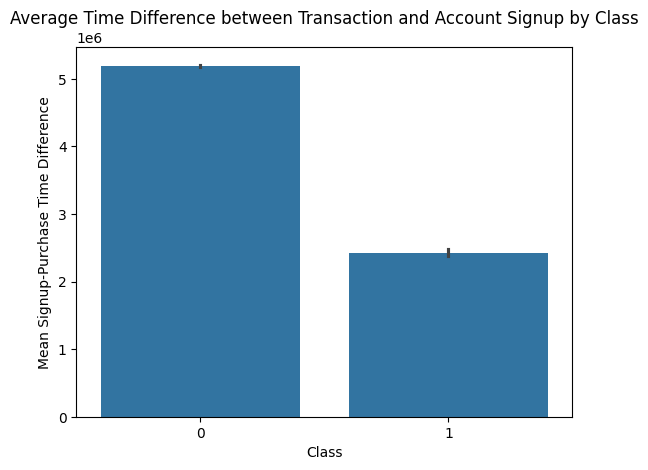

In [32]:
# Plotting bar chart to visualise the average signup-purchase time difference for each class
sns.barplot(data=df_clean, x='class', y='signup_purchase_time_diff')
plt.xlabel('Class')
plt.ylabel('Mean Signup-Purchase Time Difference')
plt.title('Average Time Difference between Transaction and Account Signup by Class')
plt.show()

Insights: The 2 plots above show that non-fraudulent users have a longer period of time between account signup and making transaction, as compared to fraudulent users, which implies that fraudulent users could be signing up for accounts solely to commit frauds.

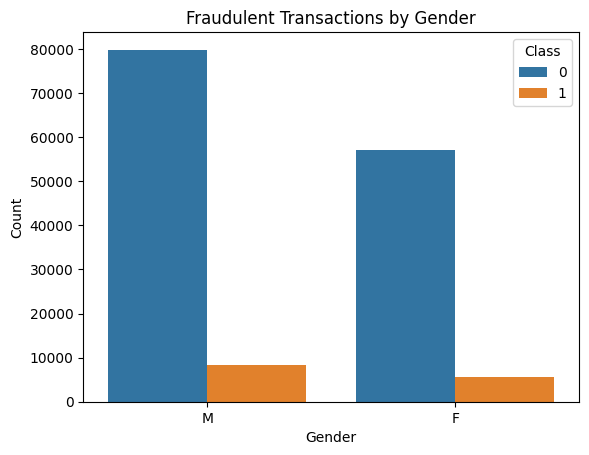

In [33]:
# Plotting bar chart to visualise the numbers of fraudulent users vs non-fraudulent users by gender
sns.countplot(data=df_clean, x='sex', hue='class')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Fraudulent Transactions by Gender')
plt.legend(title='Class')
plt.show()

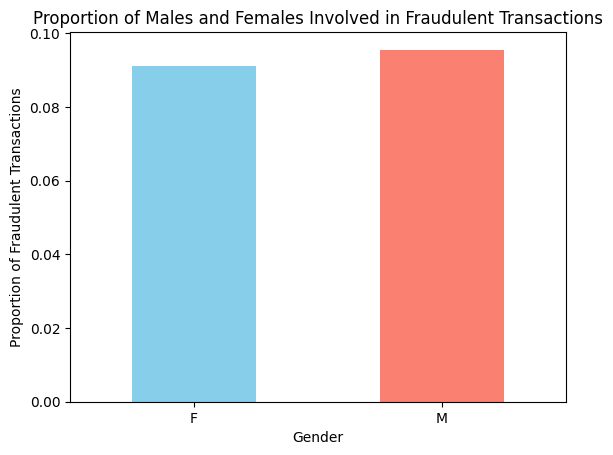

In [34]:
# Plotting bar chart to visualise the proportion of male vs females being frauds
fraud_proportion_by_gender = df_clean.groupby('sex')['class'].apply(lambda x: (x == 1).mean())

fraud_proportion_by_gender.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Gender')
plt.ylabel('Proportion of Fraudulent Transactions')
plt.title('Proportion of Males and Females Involved in Fraudulent Transactions')
plt.xticks(rotation=0)
plt.show()

Insights: While more males appear to be fraudulent users, the proportion of males and females fraud users appear to imply that there is little association between a user being fraud and his/her gender.

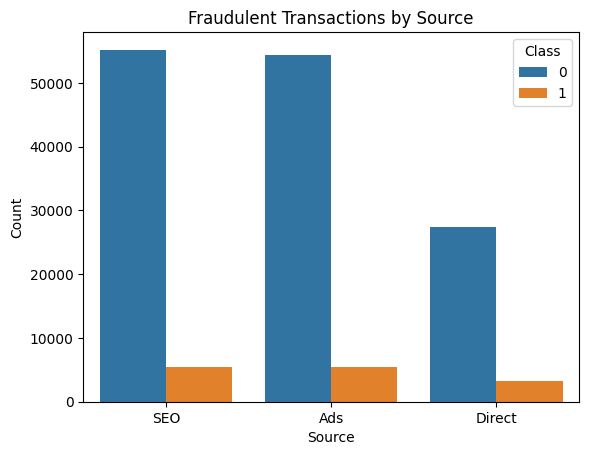

In [37]:
# Plotting bar chart to visualise the numbers of fraudulent users vs non-fraudulent users by Source
sns.countplot(data=df_clean, x='source', hue='class')
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Fraudulent Transactions by Source')
plt.legend(title='Class')
plt.show()

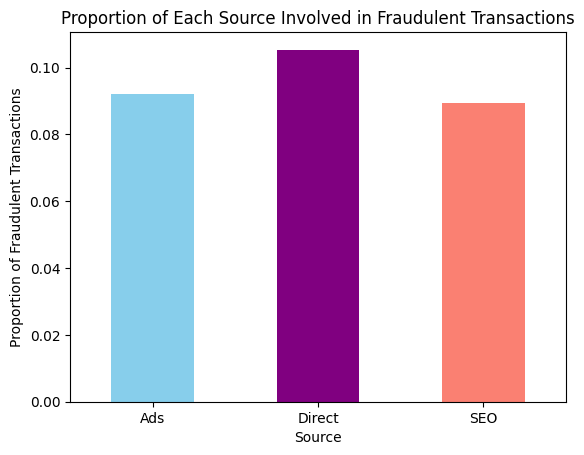

In [40]:
# Plotting bar chart to visualise the proportion of each source's customers being frauds
fraud_proportion_by_gender = df_clean.groupby('source')['class'].apply(lambda x: (x == 1).mean())

fraud_proportion_by_gender.plot(kind='bar', color=['skyblue', 'purple','salmon'])
plt.xlabel('Source')
plt.ylabel('Proportion of Fraudulent Transactions')
plt.title('Proportion of Each Source Involved in Fraudulent Transactions')
plt.xticks(rotation=0)
plt.show()

Insights: While the number of fradulent users for each source appears similar, fraudulent users who source the ecommerce platform directly are the most compared to the 3 groups. This could potentially mean that these fraudulent users have already targeted the platform, and hence there is no need to enter the platform via ads or SEOs.

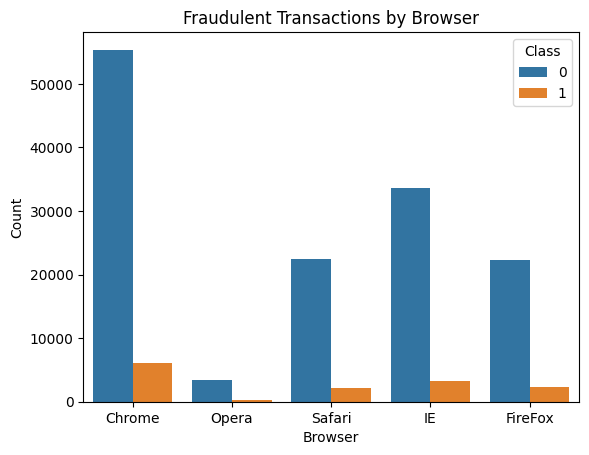

In [41]:
# Plotting bar chart to visualise the numbers of fraudulent users vs non-fraudulent users by Browser
sns.countplot(data=df_clean, x='browser', hue='class')
plt.xlabel('Browser')
plt.ylabel('Count')
plt.title('Fraudulent Transactions by Browser')
plt.legend(title='Class')
plt.show()

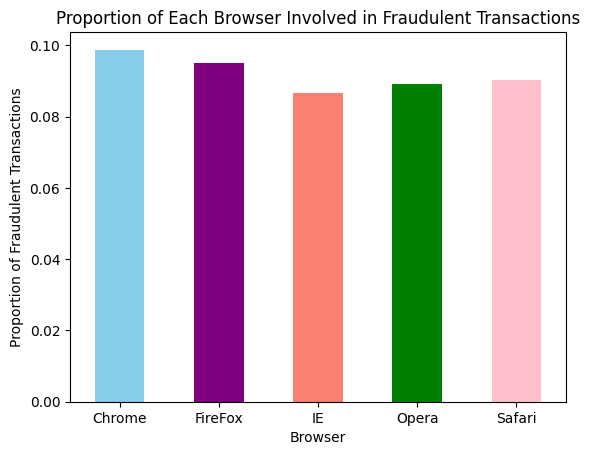

In [43]:
# Plotting bar chart to visualise the proportion of each browser's users being frauds
fraud_proportion_by_gender = df_clean.groupby('browser')['class'].apply(lambda x: (x == 1).mean())

fraud_proportion_by_gender.plot(kind='bar', color=['skyblue', 'purple','salmon','green','pink'])
plt.xlabel('Browser')
plt.ylabel('Proportion of Fraudulent Transactions')
plt.title('Proportion of Each Browser Involved in Fraudulent Transactions')
plt.xticks(rotation=0)
plt.show()

Insights: Proportion wise, all browsers have similar level of fraudulent users. However, Chrome has the highest user count, and therefore fraudulent users are more likely to reach the platform through Chrome.